In [2]:
import fastf1 as ff1
import numpy as np
import pandas as pd
import math

#from backend.utils import sectors
from fastapi import FastAPI, Query

sector_dict = {
    'British Grand Prix': [0,350,800,1150,1830,2300,2930,3170,3600,4200,4900,5130,5400,5650],
    'Italian Grand Prix': [0,800,1050,2050,2300,2700,2950,3850,4200,5000,5500],
    'Austrian Grand Prix': [0,330,500,1300,1450,2100,2250,2600,3100,3600,4020],
    'Spanish Grand Prix': [0,750,1250,1600,1870,2000,2200,2450,2600,2800,3000,3370,3900,4400],
    'Bahrain Grand Prix': [0,600,850,1400,1650,2100,2300,2600,2750,3350,3900,4200,4790,5000],
    'Abu Dhabi Grand Prix': [0,275,700,1300,1520,2550,2750,3550,3850,4250,4375,4700,5100]
}

labels_spanish = {
    0: 'Straight',
    1: 'Fast',
    2: 'Straight',
    3: 'Medium',
    4: 'Straight',
    5: 'Medium',
    6: 'Straight',
    7: 'Fast',
    8: 'Straight',
    9: 'Fast',
    10: 'Straight',
    11: 'Medium',
    12: 'Slow',
    13: 'Straight'
}

labels_britian = {
    0: 'Straight',
    1: 'Fast',
    2: 'Slow',
    3: 'Straight',
    4: 'Medium',
    5: 'Straight',
    6: 'Fast',
    7: 'Straight',
    8: 'Fast',
    9: 'Straight',
    10: 'Medium',
    11: 'Straight',
    12: 'slow',
    13: 'Straight'
}

labels_abuDhabi = {
    0: 'Straight',
    1: 'Medium',
    2: 'Straight',
    3: 'Slow',
    4: 'Straight',
    5: 'Slow',
    6: 'Straight',
    7: 'Medium',
    8: 'Straight',
    9: 'Slow',
    10: 'Medium',
    11: 'Fast',
    12: 'Straight'
}

labels_bahrain = {
    1: 'Straight',
    2: 'Slow',
    3: 'Straight',
    4: 'Medium',
    5: 'Fast',
    6: 'Slow',
    7: 'Straight',
    8: 'Slow',
    9: 'Straight',
    10: 'Fast',
    11: 'Medium',
    12: 'Straight',
    13: 'Medium',
    14: 'Straight'
}

labels_austria = {
    0: 'Straight',
    1: 'Medium',
    2: 'Straight',
    3: 'Slow',
    4: 'Straight',
    5: 'Slow',
    6: 'Straight',
    7: 'Fast',
    8: 'Straight',
    9: 'Fast',
    10: 'Straight'
}

labels_italy = {
    0: 'Straight',
    1: 'Slow',
    2: 'Straight',
    3: 'Slow',
    4: 'Medium',
    5: 'Medium',
    6: 'Straight',
    7: 'Fast',
    8: 'Straight',
    9: 'Fast',
    10: 'Straight'
}

label_dict = {
    'Spanish Grand Prix': labels_spanish,
    'British Grand Prix': labels_britian,
    'Bahrain Grand Prix': labels_bahrain,
    'AbuDhabi Grand Prix': labels_abuDhabi,
    'Italian Grand Prix': labels_italy,
    'Austrian Grand Prix': labels_austria
}

def get_loaded_session(year, name, identifier):
    s = ff1.get_session(year, name, identifier)
    s.load()
    return s


In [3]:
def get_average_loss_to_fastest(session_name: str, identifier: str,  drivers: list[str] = Query(None), session_years: list[int] = Query(None)):
    telemetry_list = []
    
    # Track overall fastest lap across all loaded laps
    fastest_lap_time = None
    fastest_driver_overall = None
    fastest_year_overall = None

    ### ---- Load telemetry data ---- ###

    # Load all sessions and drivers' fastest laps
    for year in session_years:
        session_event = get_loaded_session(year, session_name, identifier)

        for driver in drivers:
            lap = session_event.laps.pick_drivers(driver).pick_fastest()

            # skip if no lap found
            if lap is None or getattr(lap, "empty", False):
                continue

            # Record overall fastest lap
            if 'LapTime' in lap.index:
                lap_time = lap['LapTime']
            else:
                # fallback attribute access if structure differs
                lap_time = getattr(lap, 'LapTime', None)

            if lap_time is not None and (fastest_lap_time is None or lap_time < fastest_lap_time):
                fastest_lap_time = lap_time
                fastest_driver_overall = driver
                fastest_year_overall = year

            telemetry = lap.get_telemetry().add_distance()

            telemetry["Driver"] = driver
            telemetry["Year"] = year
            telemetry["DriverYear"] = f"{driver}_{year}"

            telemetry_list.append(telemetry)


    print(fastest_driver_overall, fastest_year_overall)
    # Concatenate all telemetry data
    telemetry_all = pd.concat(telemetry_list, ignore_index=True)

    ### ---- Get mini sectors, labels added later ---- ###

    # Create minisectors based on predefined sector bounds or equal divisions
    if session_name in sector_dict.keys():
        sector_bounds = sector_dict[session_name]
    else:
        num_minisectors = 12
        sector_bounds = [0] * (num_minisectors + 1)
        total_dist = telemetry_all['Distance'].max()

        for i in range(1, num_minisectors + 1):
            sector_bounds[i] = math.ceil(i * (total_dist / num_minisectors))

    telemetry_all['Minisector'] = np.digitize(
        telemetry_all['Distance'], bins=sector_bounds, right=False
    )

    # Get sector lengths
    sector_lengths = []
    for i in range(1, len(sector_bounds)):
        sector_lengths.append(sector_bounds[i] - sector_bounds[i-1])
    sector_length_df = pd.DataFrame({
        'Minisector': list(range(1, len(sector_bounds))),
        'SectorLength': sector_lengths
    })

    ### ---- Calculate average time and time loss to fastest driver per minisector ---- ### 

    # Get average speed per driver per minisector
    avg_speed = (
        telemetry_all
        .groupby(['Minisector', 'DriverYear'])['Speed']
        .mean()
        .reset_index()
    )

    # Add sector labels
    labels = label_dict.get(session_name, {})
    avg_speed['MinisectorLabel'] = avg_speed['Minisector'].map(labels)

    # Transform speed to time per sector (in seconds)
    avg_speed = avg_speed.merge(sector_length_df, on='Minisector')
    avg_speed['Speed'] = avg_speed['Speed']/3.6 # convert to m/s
    avg_speed['Time_sec'] = avg_speed['SectorLength'] / avg_speed['Speed']


    # Find speed difference per minisector to overall fastest driver
    avg_speed = avg_speed.merge(
        avg_speed[avg_speed['DriverYear'] == f"{fastest_driver_overall}_{fastest_year_overall}"][['Minisector', 'Time_sec']],
        on='Minisector',
        suffixes=('', '_Fastest')
    )

    avg_speed['Diff_to_Fastest_sec'] =  avg_speed['Time_sec'] - avg_speed['Time_sec_Fastest']

    #Find the average time loss per minisector label for each driver
    avg_speed = (
        avg_speed
        .groupby(['DriverYear','MinisectorLabel'])['Diff_to_Fastest_sec']
        .mean()
        .reset_index()
    )

    avg_speed['FastestOverallDriver'] = fastest_driver_overall
    avg_speed['FastestOverallYear'] = fastest_year_overall

    return avg_speed.to_dict(orient='records')

In [4]:
H = get_average_loss_to_fastest(session_name = "Bahrain Grand Prix", identifier = "Q", drivers=["HAM","VER","LEC"], session_years = [2021,2022])

print(H)

req         WARNING 	DEFAULT CACHE ENABLED! (264.44 MB) /Users/lukasrasche/Library/Caches/fastf1
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '16', '10', '3', '4', '55', '14', '18', '11', '99', '22', '7', '63', '31', '6', '5', '47', '9']
core          

VER 2021
[{'DriverYear': 'HAM_2021', 'MinisectorLabel': 'Fast', 'Diff_to_Fastest_sec': 0.015415828760675154, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2021', 'MinisectorLabel': 'Medium', 'Diff_to_Fastest_sec': -0.0013095371704645586, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2021', 'MinisectorLabel': 'Slow', 'Diff_to_Fastest_sec': 0.06961366086289662, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2021', 'MinisectorLabel': 'Straight', 'Diff_to_Fastest_sec': 0.03079264988891488, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2022', 'MinisectorLabel': 'Fast', 'Diff_to_Fastest_sec': 0.17464176311598, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2022', 'MinisectorLabel': 'Medium', 'Diff_to_Fastest_sec': 0.3369491548586862, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2022', 'Minise

In [5]:
Driver = H[0]['FastestOverallDriver']
Year = H[0]['FastestOverallYear']
Diffs = H

In [6]:
print(Diffs)

[{'DriverYear': 'HAM_2021', 'MinisectorLabel': 'Fast', 'Diff_to_Fastest_sec': 0.015415828760675154, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2021', 'MinisectorLabel': 'Medium', 'Diff_to_Fastest_sec': -0.0013095371704645586, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2021', 'MinisectorLabel': 'Slow', 'Diff_to_Fastest_sec': 0.06961366086289662, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2021', 'MinisectorLabel': 'Straight', 'Diff_to_Fastest_sec': 0.03079264988891488, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2022', 'MinisectorLabel': 'Fast', 'Diff_to_Fastest_sec': 0.17464176311598, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2022', 'MinisectorLabel': 'Medium', 'Diff_to_Fastest_sec': 0.3369491548586862, 'FastestOverallDriver': 'VER', 'FastestOverallYear': 2021}, {'DriverYear': 'HAM_2022', 'MinisectorLabel

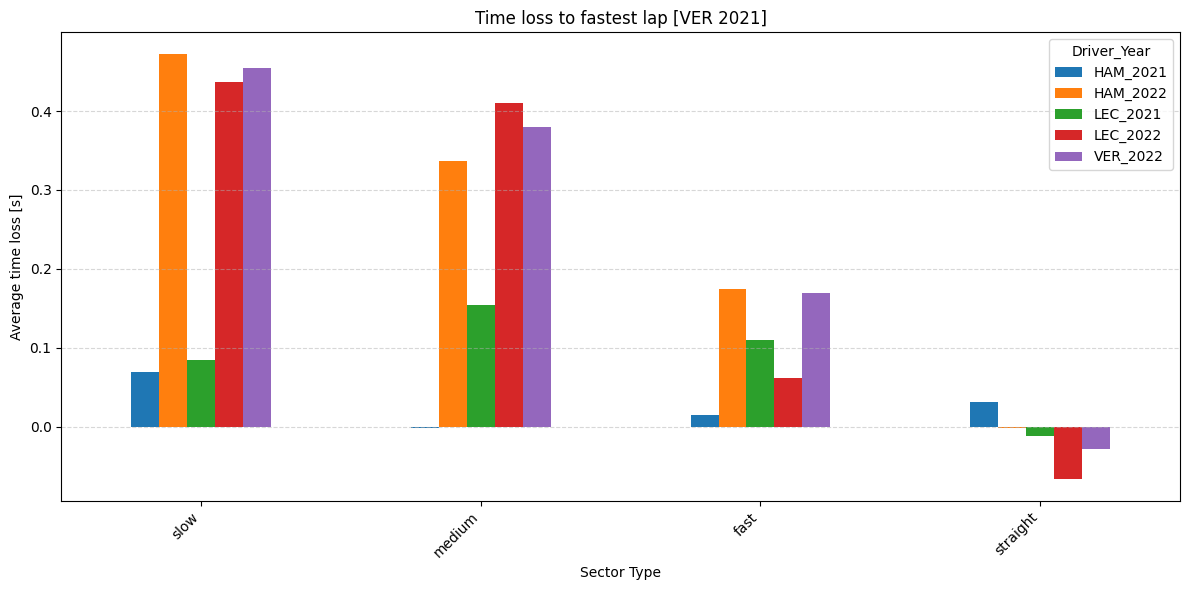

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Exclude the overall fastest driver (any year) from the plotted data
Diffs = [d for d in Diffs if d['DriverYear'] != f"{Driver}_{Year}"]

# Use the Diffs variable computed earlier
df = pd.DataFrame(Diffs)

# Normalize label text to group 'Slow' / 'slow' etc.
df['LabelKey'] = df['MinisectorLabel'].astype(str).str.strip().str.lower()

# Pivot so each DriverYear becomes a column and each label a row
pt = df.pivot_table(index='LabelKey', columns='DriverYear', values='Diff_to_Fastest_sec', aggfunc='mean')

# Preferred order changed to: slow, medium, fast, straight
preferred_order = ['slow', 'medium', 'fast', 'straight']
order = [lbl for lbl in preferred_order if lbl in pt.index] + [lbl for lbl in pt.index if lbl not in preferred_order]
pt = pt.loc[order]

# Plot grouped bar chart: bars for the same label will be adjacent
fig, ax = plt.subplots(figsize=(12, 6))
pt.plot(kind='bar', ax=ax)

ax.set_xlabel('Sector Type')
ax.set_ylabel('Average time loss [s]')
ax.set_title(f'Time loss to fastest lap [{Driver} {Year}]')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Driver_Year', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
#plt.grid(False)
plt.show()